## Boosting on Voice gender dataset

Gender Recognition by Voice and Speech Analysis

datasource: https://www.kaggle.com/primaryobjects/voicegender

author: Elvira Dzhuraeva

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import xgboost as xgb
import lightgbm as lgb

/Users/edzhurae/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
df = pd.read_csv('voice.csv')
df.head()

meanfreq        sd    median       Q25       Q75       IQR       skew  \
0  0.059781  0.064241  0.032027  0.015071  0.090193  0.075122  12.863462   
1  0.066009  0.067310  0.040229  0.019414  0.092666  0.073252  22.423285   
2  0.077316  0.083829  0.036718  0.008701  0.131908  0.123207  30.757155   
3  0.151228  0.072111  0.158011  0.096582  0.207955  0.111374   1.232831   
4  0.135120  0.079146  0.124656  0.078720  0.206045  0.127325   1.101174   

          kurt    sp.ent       sfm  ...  centroid   meanfun    minfun  \
0   274.402906  0.893369  0.491918  ...  0.059781  0.084279  0.015702   
1   634.613855  0.892193  0.513724  ...  0.066009  0.107937  0.015826   
2  1024.927705  0.846389  0.478905  ...  0.077316  0.098706  0.015656   
3     4.177296  0.963322  0.727232  ...  0.151228  0.088965  0.017798   
4     4.333713  0.971955  0.783568  ...  0.135120  0.106398  0.016931   

     maxfun   meandom    mindom    maxdom   dfrange   modindx  label  
0  0.275862  0.007812  0.007812  0.007812  0.000000  0.000000   male  
1  0.250000  0.009014  0.007812  0.054688  0.046875  0.052632   male  
2  0.271186  0.007990  0.007812  0.015625  0.007812  0.046512   male  
3  0.250000  0.201497  0.007812  0.562500  0.554688  0.247119   male  
4  0.266667  0.712812  0.007812  5.484375  5.476562  0.208274   male  

[5 rows x 21 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
meanfreq    3168 non-null float64
sd          3168 non-null float64
median      3168 non-null float64
Q25         3168 non-null float64
Q75         3168 non-null float64
IQR         3168 non-null float64
skew        3168 non-null float64
kurt        3168 non-null float64
sp.ent      3168 non-null float64
sfm         3168 non-null float64
mode        3168 non-null float64
centroid    3168 non-null float64
meanfun     3168 non-null float64
minfun      3168 non-null float64
maxfun      3168 non-null float64
meandom     3168 non-null float64
mindom      3168 non-null float64
maxdom      3168 non-null float64
dfrange     3168 non-null float64
modindx     3168 non-null float64
label       3168 non-null object
dtypes: float64(20), object(1)
memory usage: 519.8+ KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a23378e80>,
      dtype=object)

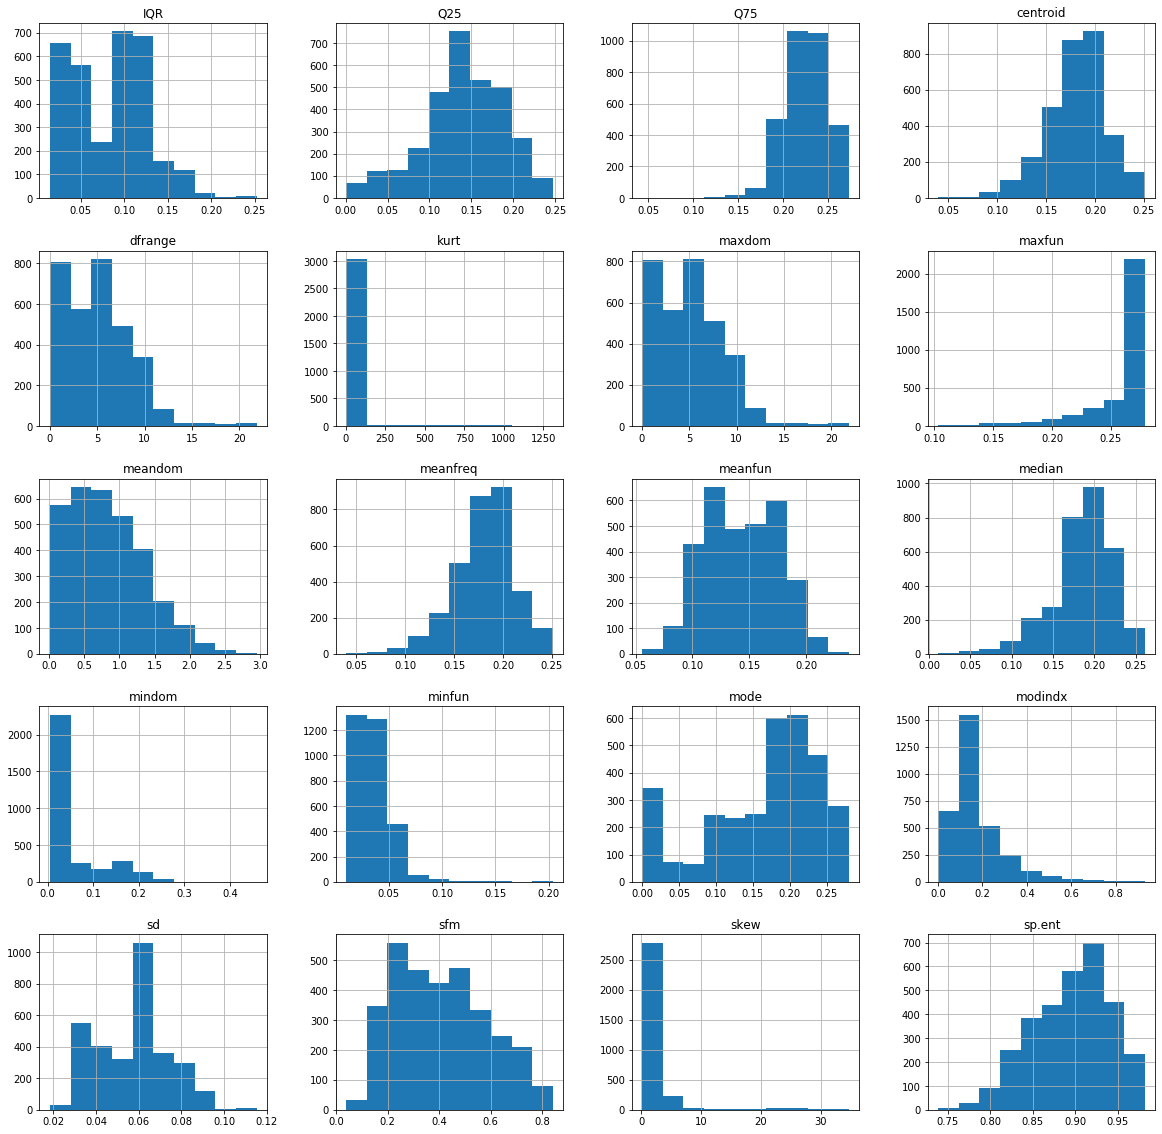

In [4]:
df.hist(figsize=(20,20))

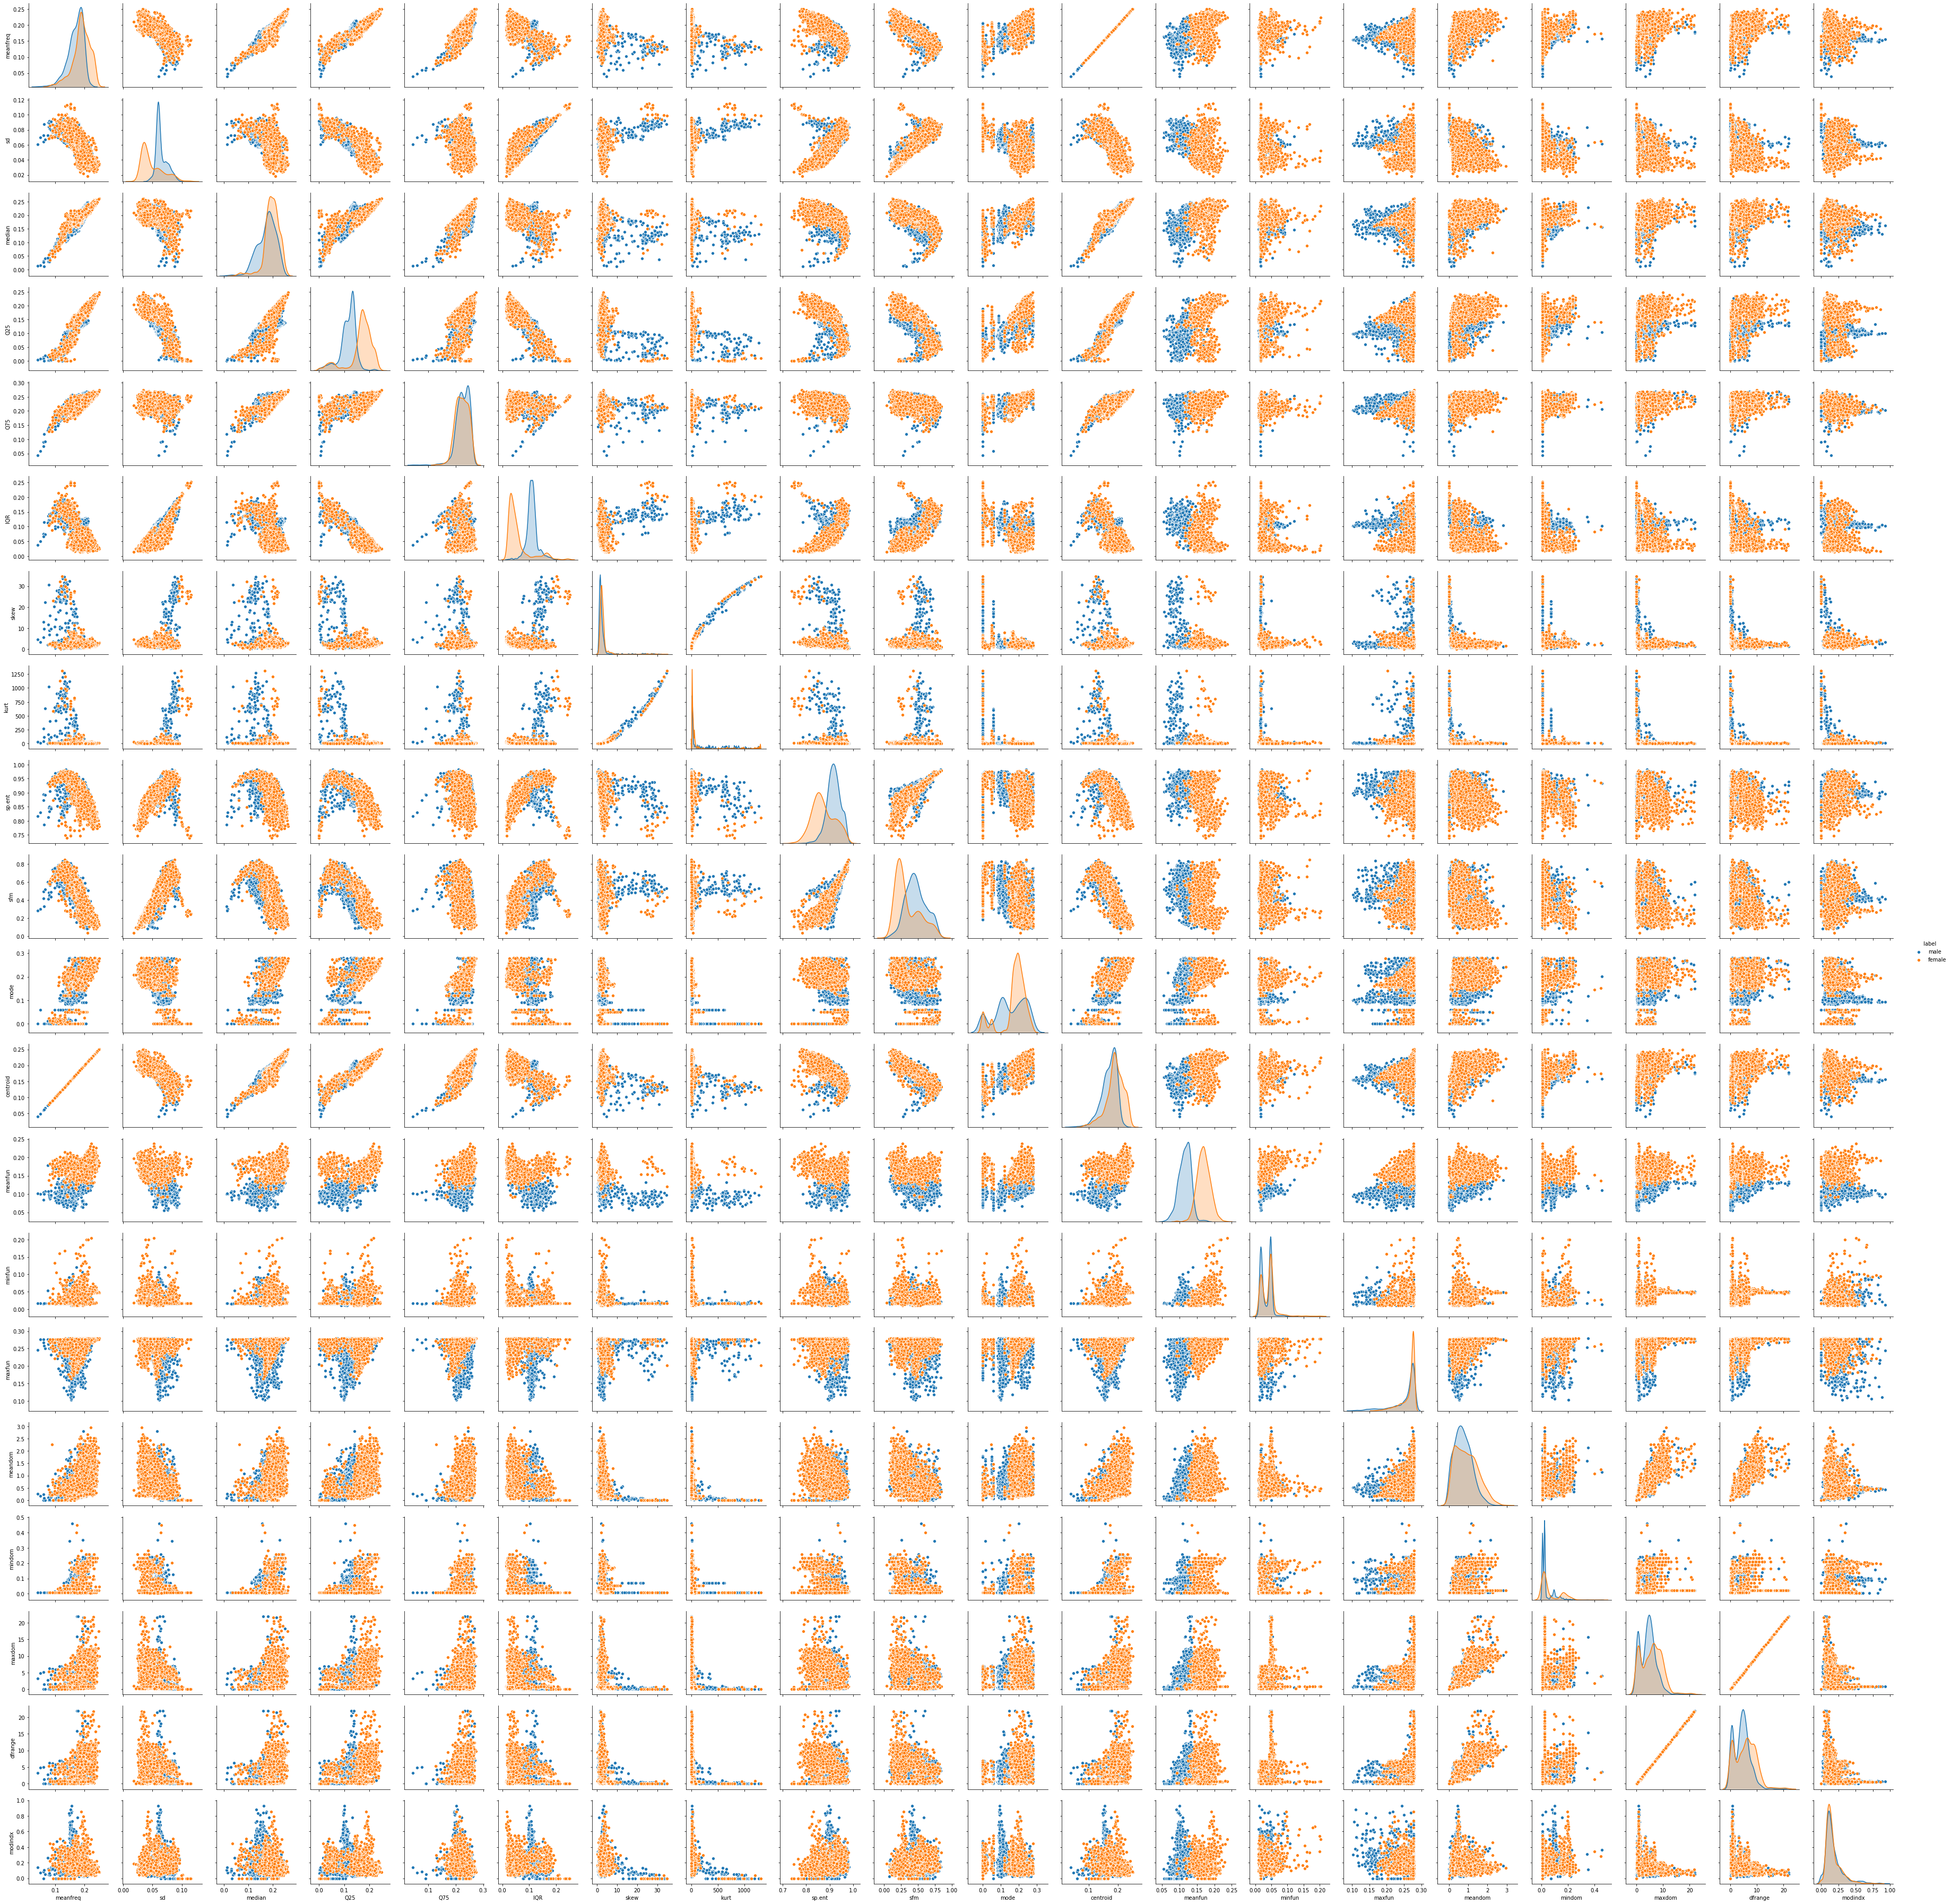

In [5]:
sns.pairplot(df, hue="label")

In [6]:
df.isnull().sum()

meanfreq    0
sd          0
median      0
Q25         0
Q75         0
IQR         0
skew        0
kurt        0
sp.ent      0
sfm         0
mode        0
centroid    0
meanfun     0
minfun      0
maxfun      0
meandom     0
mindom      0
maxdom      0
dfrange     0
modindx     0
label       0
dtype: int64

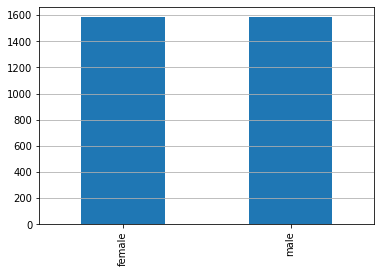

In [7]:
df['label'].value_counts().plot.bar(figsize=(6, 4))
plt.grid(axis='y')

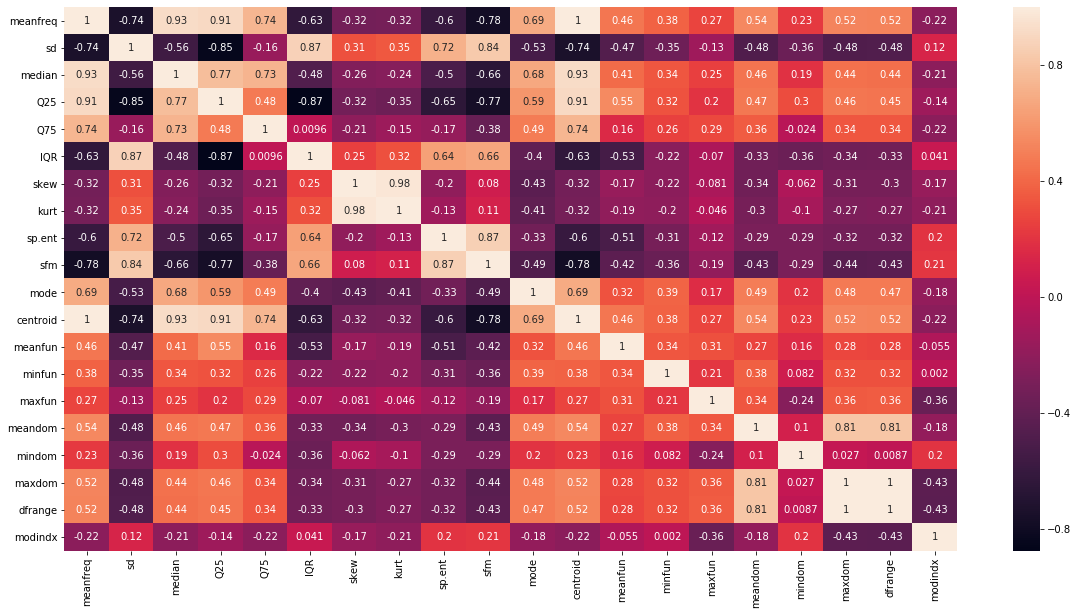

In [8]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), annot=True)

### Данные чистые и сбалансированные, можно двигаться дальше

In [9]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
encoded = labelencoder.fit_transform(df['label'])
encoded

array([1, 1, 1, ..., 0, 0, 0])

In [10]:
Y = encoded
X = df.drop('label', axis=1)

In [11]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
print(X_train.shape)
print(X_test.shape)

(2217, 20)
(951, 20)


In [16]:
import sklearn.metrics as metrics
def printROC(preds):
    fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [13]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

def quality(prediction_y, true_y, name):
    accuracy = accuracy_score(prediction_y, true_y)
    precision = precision_score(prediction_y, true_y)
    recall = recall_score(prediction_y, true_y)
    f1 = f1_score(prediction_y, true_y)
    print("Metrics for {}\nAccuracy:  {:.3f}\nPrecision: {:.3f}\nRecall:    {:.3f}\nF1-score:  {:.3f}".format(name,
        accuracy, precision, recall, f1
    ))


In [14]:
lc = LogisticRegressionCV()
lc.fit(X_train, Y_train)
Y_pred = lc.predict(X_test)

/Users/edzhurae/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


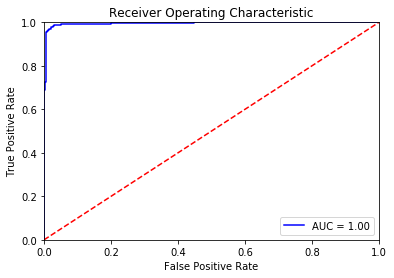

In [24]:
printROC(lc.predict_proba(X_test)[:,1])

In [15]:
quality(Y_pred, Y_test, 'LR')

Metrics for LR
Accuracy:  0.977
Precision: 0.990
Recall:    0.966
F1-score:  0.978


In [19]:
from sklearn.model_selection import RandomizedSearchCV

def randomized_cv(model, param_grid, x_train=X_train, y_train=Y_train):
    grid_search = RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(x_train, y_train)
    print('model {} best accuracy score is {}'.format(model.__class__.__name__, grid_search.best_score_))
    print(grid_search.best_score_)
    pred_proba = grid_search.predict_proba(X_test)
    printROC(pred_proba[:, 1])
    return grid_search.best_estimator_

model XGBClassifier best accuracy score is 0.9720342805593144
0.9720342805593144


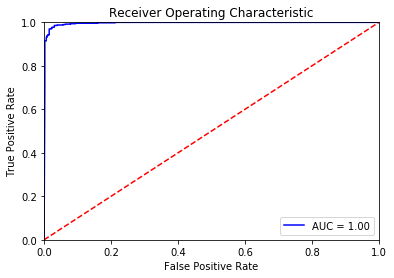

In [20]:
import xgboost as xgb

param_grid = {
    'max_depth': [2, 3, 6],
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.025, 0.04]
}
# xgbc = xgb.XGBClassifier()
xgb = randomized_cv(xgb.XGBClassifier(), param_grid)

model LGBMClassifier best accuracy score is 0.9788001804239964
0.9788001804239964


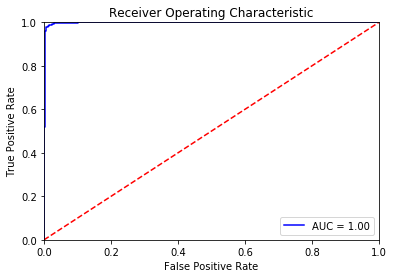

In [21]:
import lightgbm as lgb

param_grid = {
    'max_depth': [2, 3, 4, 5],
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.02, 0.05]
}
model = randomized_cv(lgb.LGBMClassifier(), param_grid)

In [22]:
import h2o
import numpy as np
import math
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(nthreads=-1, strict_version_check=True)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_131"; Java(TM) SE Runtime Environment (build 1.8.0_131-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.131-b11, mixed mode)
  Starting server from /Users/edzhurae/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/rw/g2c0r4fs0t73v457sqp_h2rh0000gn/T/tmp33dd1hq9
  JVM stdout: /var/folders/rw/g2c0r4fs0t73v457sqp_h2rh0000gn/T/tmp33dd1hq9/h2o_edzhurae_started_from_python.out
  JVM stderr: /var/folders/rw/g2c0r4fs0t73v457sqp_h2rh0000gn/T/tmp33dd1hq9/h2o_edzhurae_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       America/Los_Angeles
H2O data parsing timezone:  UTC
H2O cluster version:        3.26.0.10
H2O cluster version age:    4 days
H2O cluster name:           H2O_from_python_edzhurae_w5mtft
H2O cluster total nodes:    1
H2O cluster free memory:    3.556 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:       {'http': None, 'https': None}
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python version:             3.7.3 final
--------------------------  ------------------------------------------------------------------

In [25]:
data = np.c_[X_train, Y_train]
data = pd.DataFrame(data, columns=['C{}'.format(idx + 1) for idx in range(data.shape[-1])])

train_df_h2o = h2o.H2OFrame(python_obj=data)
train_df_h2o['C21'] = train_df_h2o['C21'].asfactor()

train_df_h2o.show()

Parse progress: |█████████████████████████████████████████████████████████| 100%


C1 C2 C3 C4 C5 C6 C7 C8 C9 C10 C11 C12 C13 C14 C15 C16 C17 C18 C19 C20 C21 
 
 
 0.64843 0.272649 1.21975 -0.102817 1.33191 0.852922 -0.35857 -0.232563 -0.195874 -0.531178 1.17843 0.64843 -0.48827 0.572774 0.672624 1.64068 -0.461523 0.417073 0.425505 0.0482363 1 
 1.11379 -1.14952 0.855371 1.3562 0.0334494 -1.52464 0.0560419 -0.154578 -1.67952 -1.0755 0.721301 1.11379 1.02173 0.555549 0.672624 2.28852 -0.461523 1.0828 1.09144 -0.545544 0 
 -1.03313 0.672786 -0.634776 -0.955852 -0.92535 0.576303 -0.279984 -0.215694 1.22367 1.35502 -1.05131 -1.03313 -1.52632 -1.06461 -0.0258618 -0.682182 -0.708404 -0.0489339 -0.0362105 -0.319542 1 
 -0.28239 0.117234 -0.191047 -0.590216 -0.457234 0.418924 -0.392979 -0.231643 0.544999 -0.267499 0.577855 -0.28239 -1.60025 -1.06461 -3.23305 -0.916104 0.526003 -0.6148 -0.624454 -0.834225 1 
 -0.155706 1.16227 0.107436 -0.458046 1.13249 1.14692 -0.207872 -0.2015 1.01245 0.994054 1.20325 -0.155706 -0.37376 0.582726 0.672624 -0.695359 -0.461523 -0.561542 -0.553421 -0.88976 1 
 0.819317 0.156983 1.11386 0.127277 1.31246 0.580364 -0.444808 -0.240547 0.483013 -0.285216 1.0355 0.819317 -0.303083 0.540973 0.672624 1.23515 -0.461523 0.476988 0.485439 -0.383787 1 
 0.323525 -1.65723 0.191102 0.729325 -0.739932 -1.23869 -0.17166 -0.210284 -1.62615 -1.24076 0.0994341 0.323525 0.839873 -0.985833 -0.545946 0.915187 2.00729 0.483646 0.447703 0.729103 0 
 -0.785479 0.031148 -0.555419 0.260605 -1.75856 -1.26819 0.723775 0.118845 -0.299806 0.390918 -0.000545322 -0.785479 0.44637 -1.24188 -1.82095 -1.22463 0.171111 -1.24641 -1.24988 -0.67126 0 
 0.0755771 1.19358 -0.130514 -0.205319 1.38576 0.999305 -0.118835 -0.179357 0.743941 0.740716 1.24787 0.0755771 -0.551385 -1.03215 0.114817 -0.730569 -0.708404 -0.412863 -0.400255 -0.487359 1 
 -0.177115 -0.143043 -0.0526621 -0.100598 -0.550528 -0.189725 -0.338818 -0.222594 0.422041 0.0795134 0.220519 -0.177115 -0.969469 0.536152 0.461717 0.390469 -0.461523 0.729964 0.738495 -0.570672 1

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2217 entries, 0 to 2216
Data columns (total 21 columns):
C1     2217 non-null float64
C2     2217 non-null float64
C3     2217 non-null float64
C4     2217 non-null float64
C5     2217 non-null float64
C6     2217 non-null float64
C7     2217 non-null float64
C8     2217 non-null float64
C9     2217 non-null float64
C10    2217 non-null float64
C11    2217 non-null float64
C12    2217 non-null float64
C13    2217 non-null float64
C14    2217 non-null float64
C15    2217 non-null float64
C16    2217 non-null float64
C17    2217 non-null float64
C18    2217 non-null float64
C19    2217 non-null float64
C20    2217 non-null float64
C21    2217 non-null float64
dtypes: float64(21)
memory usage: 363.8 KB


In [27]:
hf = h2o.H2OFrame(df)

response = "label"
hf[response] = hf[response].asfactor()
predictors = hf.columns
del predictors[20]

Parse progress: |█████████████████████████████████████████████████████████| 100%
['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt', 'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun', 'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx']


In [28]:
train, valid, test = hf.split_frame(
    ratios=[0.6,0.2], 
    seed=1234, 
    destination_frames=['train.hex','valid.hex','test.hex']
)

In [29]:
gbm = H2OGradientBoostingEstimator()
gbm.train(x=predictors, y=response, training_frame=train)

## Show a detailed model summary
print(gbm)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1573547428718_1


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0               50.0                      50.0              14811.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0        5.0        5.0         5.0        10.0        25.0         19.0



ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.001744702326544338
RMSE: 0.04176963402454393
LogLoss: 0.016133666645300783
Mean Per-Class Error: 0.0005230125523012497
AUC: 0.9999967174944416
pr_auc: 0.978030198858467
Gini: 0.9999934349888833

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5676350035383926: 


female   male   Error           Rate
0  female   956.0    0.0     0.0    (0.0/956.0)
1    male     1.0  955.0   0.001    (1.0/956.0)
2   Total   957.0  955.0  0.0005   (1.0/1912.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold       value    idx
0                        max f1   0.567635    0.999477  189.0
1                        max f2   0.343748    0.999373  193.0
2                  max f0point5   0.567635    0.999791  189.0
3                  max accuracy   0.567635    0.999477  189.0
4                 max precision   0.995653    1.000000    0.0
5                    max recall   0.343748    1.000000  193.0
6               max specificity   0.995653    1.000000    0.0
7              max absolute_mcc   0.567635    0.998955  189.0
8    max min_per_class_accuracy   0.567635    0.998954  189.0
9   max mean_per_class_accuracy   0.567635    0.999477  189.0
10                      max tns   0.995653  956.000000    0.0
11                      max fns   0.995653  935.000000    0.0
12                      max fps   0.004025  956.000000  399.0
13                      max tps   0.343748  956.000000  193.0
14                      max tnr   0.995653    1.000000    0.0
15                      max fnr   0.995653    0.978033    0.0
16                      max fpr   0.004025    1.000000  399.0
17                      max tpr   0.343748    1.000000  193.0


Gains/Lift Table: Avg response rate: 50.00 %, avg score: 50.00 %


group  cumulative_data_fraction  lower_threshold      lift  \
0         1                  0.010460         0.995617  2.000000   
1         2                  0.022490         0.995495  2.000000   
2         3                  0.037134         0.995417  2.000000   
3         4                  0.057531         0.995395  2.000000   
4         5                  0.100418         0.995189  2.000000   
5         6                  0.150105         0.994985  2.000000   
6         7                  0.206590         0.994836  2.000000   
7         8                  0.300209         0.994252  2.000000   
8         9                  0.400105         0.990567  2.000000   
9        10                  0.500000         0.459824  1.989529   
10       11                  0.599895         0.012264  0.010471   
11       12                  0.699791         0.006450  0.000000   
12       13                  0.807531         0.005313  0.000000   
13       14                  0.944561         0.005228  0.000000   
14       15                  1.000000         0.004000  0.000000   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          2.000000       1.000000  0.995654                  1.000000   
1          2.000000       1.000000  0.995528                  1.000000   
2          2.000000       1.000000  0.995421                  1.000000   
3          2.000000       1.000000  0.995395                  1.000000   
4          2.000000       1.000000  0.995282                  1.000000   
5          2.000000       1.000000  0.995108                  1.000000   
6          2.000000       1.000000  0.994880                  1.000000   
7          2.000000       1.000000  0.994651                  1.000000   
8          2.000000       1.000000  0.993051                  1.000000   
9          1.997908       0.994764  0.948138                  0.998954   
10         1.666957       0.005236  0.049238                  0.833479   
11         1.428999       0.000000  0.008700                  0.714499   
12         1.238342       0.000000  0.005723                  0.619171   
13         1.058693       0.000000  0.005231                  0.529347   
14         1.000000       0.000000  0.005036                  0.500000   

    cumulative_score  capture_rate  cumulative_capture_rate       gain  \
0           0.995654      0.020921                 0.020921  100.00000   
1           0.995587      0.024059                 0.044979  100.00000   
2           0.995521      0.029289                 0.074268  100.00000   
3           0.995477      0.040795                 0.115063  100.00000   
4           0.995393      0.085774                 0.200837  100.00000   
5           0.995299      0.099372                 0.300209  100.00000   
6           0.995184      0.112971                 0.413180  100.00000   
7           0.995018      0.187238                 0.600418  100.00000   
8           0.994527      0.199791                 0.800209  100.00000   
9           0.985259      0.198745                 0.998954   98.95288   
10          0.829391      0.001046                 1.000000  -98.95288   
11          0.712238      0.000000                 1.000000 -100.00000   
12          0.617975      0.000000                 1.000000 -100.00000   
13          0.529083      0.000000                 1.000000 -100.00000   
14          0.500030      0.000000                 1.000000 -100.00000   

    cumulative_gain  
0        100.000000  
1        100.000000  
2        100.000000  
3        100.000000  
4        100.000000  
5        100.000000  
6        100.000000  
7        100.000000  
8        100.000000  
9         99.790795  
10        66.695728  
11        42.899851  
12        23.834197  
13         5.869324  
14         0.000000



Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2019-11-12 00:37:02   0.091 sec              0.0       0.500000   
1     2019-11-12 00:37:02   0.426 sec              1.0       0.453859   
2     2019-11-12 00:37:02   0.507 sec              2.0       0.412734   
3     2019-11-12 00:37:02   0.563 sec              3.0       0.376279   
4     2019-11-12 00:37:02   0.612 sec              4.0       0.343713   
5     2019-11-12 00:37:02   0.645 sec              5.0       0.314645   
6     2019-11-12 00:37:02   0.679 sec              6.0       0.288969   
7     2019-11-12 00:37:02   0.712 sec              7.0       0.265506   
8     2019-11-12 00:37:02   0.743 sec              8.0       0.244901   
9     2019-11-12 00:37:03   0.791 sec              9.0       0.226428   
10    2019-11-12 00:37:03   0.818 sec             10.0       0.210572   
11    2019-11-12 00:37:03   0.860 sec             11.0       0.195624   
12    2019-11-12 00:37:03   0.912 sec             12.0       0.182704   
13    2019-11-12 00:37:03   0.956 sec             13.0       0.170327   
14    2019-11-12 00:37:03   0.997 sec             14.0       0.160289   
15    2019-11-12 00:37:03   1.039 sec             15.0       0.150528   
16    2019-11-12 00:37:03   1.063 sec             16.0       0.141099   
17    2019-11-12 00:37:03   1.091 sec             17.0       0.132821   
18    2019-11-12 00:37:03   1.116 sec             18.0       0.125484   
19    2019-11-12 00:37:03   1.148 sec             19.0       0.118758   

    training_logloss  training_auc  training_pr_auc  training_lift  \
0           0.693147      0.500000         0.000000            1.0   
1           0.604845      0.996462         0.909703            2.0   
2           0.532066      0.997150         0.983503            2.0   
3           0.471447      0.998329         0.986839            2.0   
4           0.419967      0.998472         0.981744            2.0   
5           0.375827      0.998695         0.981963            2.0   
6           0.338039      0.998764         0.992499            2.0   
7           0.304456      0.998924         0.997893            2.0   
8           0.275480      0.998978         0.994813            2.0   
9           0.249858      0.999048         0.998015            2.0   
10          0.227837      0.999057         0.994883            2.0   
11          0.207482      0.999169         0.994987            2.0   
12          0.189854      0.999208         0.998162            2.0   
13          0.173271      0.999302         0.998253            2.0   
14          0.159413      0.999351         0.998302            2.0   
15          0.146262      0.999418         0.996280            2.0   
16          0.134004      0.999500         0.997408            2.0   
17          0.122991      0.999583         0.997492            2.0   
18          0.113109      0.999636         0.998590            2.0   
19          0.104181      0.999683         0.998637            2.0   

    training_classification_error  
0                        0.500000  
1                        0.026151  
2                        0.023013  
3                        0.023013  
4                        0.019874  
5                        0.017782  
6                        0.018305  
7                        0.016213  
8                        0.014644  
9                        0.015167  
10                       0.015167  
11                       0.013598  
12                       0.013075  
13                       0.012552  
14                       0.012029  
15                       0.010983  
16                       0.010460  
17                       0.009414  
18                       0.008368  
19                       0.007845


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0    meanfun          2197.668945           1.000000    0.871508
1        IQR           138.318069           0.062939    0.054851
2        sfm            40.684978           0.018513    0.016134
3     minfun            32.478432           0.014779    0.012880
4        Q25            16.709219           0.007603    0.006626
5         sd            12.316404           0.005604    0.004884
6     sp.ent            12.292362           0.005593    0.004875
7    dfrange            10.876580           0.004949    0.004313
8     maxfun            10.872456           0.004947    0.004312
9     maxdom            10.103987           0.004598    0.004007
10      mode             8.704144           0.003961    0.003452
11   modindx             7.104393           0.003233    0.002817
12   meandom             6.440241           0.002930    0.002554
13  meanfreq             5.480700           0.002494    0.002173
14    mindom             4.396924           0.002001    0.001744
15      skew             3.487528           0.001587    0.001383
16       Q75             2.540682           0.001156    0.001008
17    median             1.067936           0.000486    0.000424
18      kurt             0.140158           0.000064    0.000056
19  centroid             0.000000           0.000000    0.000000

In [ ]:
perf = gbm.model_performance(valid)
print(perf.auc())
perf.plot()

In [ ]:
cv_gbm = H2OGradientBoostingEstimator(nfolds = 4, seed = 4567)
cv_gbm.train(x = predictors, y = response, training_frame = train.rbind(valid))

In [ ]:
# Crossvalidation
cv_summary = cv_gbm.cross_validation_metrics_summary().as_data_frame()
perf_cv = cv_gbm.model_performance(xval=True)
print(perf_cv.auc())
perf_cv.plot()

In [ ]:
gbm_lucky = H2OGradientBoostingEstimator(
  ## more trees is better if the learning rate is small enough 
  ## here, use "more than enough" trees - we have early stopping
  ntrees = 10000,                                                            

  ## smaller learning rate is better (this is a good value for most datasets, but see below for annealing)
  learn_rate = 0.01,                                                         

  ## early stopping once the validation AUC doesn't improve by at least 0.01% for 5 consecutive scoring events
  stopping_rounds = 5, stopping_tolerance = 1e-4, stopping_metric = "AUC", 

  ## sample 80% of rows per tree
  sample_rate = 0.8,                                                       

  ## sample 80% of columns per split
  col_sample_rate = 0.8,                                                   

  ## fix a random number generator seed for reproducibility
  seed = 1234,                                                             

  ## score every 10 trees to make early stopping reproducible (it depends on the scoring interval)
  score_tree_interval = 10)

gbm_lucky.train(x=predictors, y=response, training_frame=train, validation_frame=valid)

In [ ]:
perf_lucky = gbm_lucky.model_performance(valid)
print(perf_lucky.auc())
perf_lucky.plot()

 # Вывод
 
 ### В данном датасете самый лучший результат получился у Light gbm booster - 0.998 AUC score
 ### На втором месте XGboost - 0.9961 AUC
 ### На третьем H2O - 0.9957 AUC